## 集成算法
- 集成化算法是构建多个模型，通过某种策略把他们结合起来完成任务
- 目的是为了获取更好的预测效果
- 集成算法分为Bagging，Boosting，Stacking三大类


### 1、Bagging
- 训练多个模型求平均
- 训练时抽样，样本随机抽样，特征随机抽样，自助采样法（bootstrap sampling）
![Bagging](https://img0.baidu.com/it/u=2098698089,3530436934&fm=253&fmt=auto&app=138&f=PNG?w=869&h=500)


### 2、Boosting提升
- AdaBoost算法、Xgboost算法、GBDT算法
![Boosting](https://www.researchgate.net/publication/356698772/figure/fig2/AS:1096436418641951@1638422221975/The-architecture-of-Gradient-Boosting-Decision-Tree.png)

### 3、Stacking算法
![stacking](https://miro.medium.com/v2/resize:fit:720/format:webp/1*GB8U0rAuCmsQi-26EOmgKw.png)

### Random Forest随机森林
- 随机森林是一种有决策树构成的Bagging算法
- 森林：很多棵树
- 随机：样本和特征都随机抽取（有放回随机抽取）
- 分类时，让森林中每一棵决策树进行分类，森林的输出结果就是最多的那个类别
- 回归时，去所有决策树的平均值
- 随机森林可以计算自变量的重要性

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate#交叉验证
# from imblearn.over_sampling import RandomOverSampler #随机过采样
from sklearn.metrics import matthews_corrcoef
import matplotlib.pyplot as plt
import shap
from tqdm import tqdm
import time
import pandas as pd
from sklearn import datasets
import math
import joblib
from sklearn import metrics
import numpy as np
import warnings
warnings.filterwarnings("ignore")

/home/dldx/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**重要参数**
- n_estimators：森林中树的数量
- max_features :每棵决策树再选取特征是，特征的数量
- max_depth：树的最大深度
- min_samples_split：树节点最小分割的样本数

## part1、 RFR applied in ads effectiveness prediction

In [94]:
df = pd.read_csv("./data/ads_3.csv")

X = df[df.columns[:62]]
Y = df[df.columns[62:]]

In [95]:
MSE = []
RMSE = []
R_squared = []
R_squared_oob = []
feature_importance = []

for i in range(12):
    y = Y[Y.columns[i]]
    
    RF_regression = RandomForestRegressor(n_estimators=15, max_depth=4, oob_score=True, n_jobs=-1)
    RF_regression.fit(X, y)

    joblib.dump(RF_regression, "model/RF_regression/model{}.pkl".format(i+1))
    
    MSE.append(metrics.mean_squared_error(y, RF_regression.predict(X)))
    RMSE.append(math.sqrt(metrics.mean_squared_error(y, RF_regression.predict(X))))
    R_squared.append(metrics.r2_score(y, RF_regression.predict(X)))
    R_squared_oob.append(RF_regression.oob_score_)

    feature_importance.append(list(RF_regression.feature_importances_))

In [96]:
result_dic = {"MSE":MSE, "RMSE":RMSE, "R_squared":R_squared, "R_squared_oob":R_squared_oob}
result_df = pd.DataFrame(result_dic, index=Y.columns)
result_df.to_csv("result/RF_regression.csv")

feature_importance_df = pd.DataFrame(feature_importance, columns=X.columns, index=Y.columns)
feature_importance_df.to_csv("result/RFR_feature_importance.csv")

## part2、 RFC applied in ads effectiveness prediction

In [97]:
df = pd.read_csv("./data/ads_3.csv")

X = df[df.columns[:62]]
Y = df[df.columns[62:]]
Y = round(Y*10).astype(int)

In [98]:
feature_importance = []
score_list = []

for i in range(12):
    y = Y[Y.columns[i]]
    
    RF_classification = RandomForestClassifier(n_estimators=15, max_depth=4, oob_score=True)
    RF_classification.fit(X, y)

    joblib.dump(RF_classification, "model/RF_classification/model{}.pkl".format(i+1))
    score_list.append(RF_classification.oob_score_)
    

    feature_importance.append(list(RF_classification.feature_importances_))

In [99]:

result_df = pd.DataFrame(score_list, index=Y.columns, columns=['ACC'])
result_df.to_csv("./result/RF_classification.csv")

feature_importance_df = pd.DataFrame(feature_importance, columns=X.columns, index=Y.columns)
feature_importance_df.to_csv("result/RFC_feature_importance.csv")

## part3、RFC_optimized

In [7]:
df = pd.read_csv("./data/ads_3.csv")

X = df[df.columns[:62]]
Y = df[df.columns[62:]]
Y = round(Y*5).astype(int)

In [12]:
feature_importance = []
recall = []
f1_score = []
acc_validation = []
acc_test = []
mcc = []
data_bar = tqdm(range(12))
for i in data_bar:
    data_bar.set_description("model"+str(i+1))
    y = Y[Y.columns[i]]
    # 过采样
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=0)
    # ros = RandomOverSampler()  
    # X_train, y_train = ros.fit_resample(X_train, y_train)   
    
    #网格搜索参数优化
    params = {
        "n_estimators":[10,50,100,150,200],
        'max_depth':[10,15],
        'max_features':[5,20,30],
        'min_samples_leaf':[1,2,4,6],
        'min_samples_split':[4,8,10]
    }
    
    RF_classification = RandomForestClassifier()
    model = GridSearchCV(RF_classification, param_grid=params, cv=5)
    model.fit(X_train, y_train)
    n_estimators = model.best_params_["n_estimators"]
    max_depth = model.best_params_["max_depth"]
    max_features = model.best_params_["max_features"]
    min_samples_leaf = model.best_params_["min_samples_leaf"]
    min_samples_split = model.best_params_["min_samples_split"]
   

    RF_classification = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    cv_score = cross_validate(RF_classification       #实例化的模型
				, X   #完整的特征值
				, y #完整的目标值
				, cv=5         #几折交叉验证
				,scoring = ["accuracy","recall_micro","f1_micro"]   
				)
    

    recall.append(cv_score["test_recall_micro"].mean())
    f1_score.append(cv_score["test_f1_micro"].mean())
    acc_validation.append(cv_score["test_accuracy"].mean())


    RF_classification = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    RF_classification.fit(X_train, y_train)

    joblib.dump(RF_classification, "model/RF_optimized_classification/model{}.pkl".format(i+1))
    acc_test.append(RF_classification.score(X_test,y_test))
    mcc.append(matthews_corrcoef(y_test,RF_classification.predict(X_test)))
    
    feature_importance.append(list(RF_classification.feature_importances_))





model12: 100%|██████████| 12/12 [29:17<00:00, 146.48s/it]


In [13]:
result_dic = {"recall":recall, "f1_score":f1_score, "acc_validation":acc_validation, "acc_test":acc_test, "mcc":mcc}
result_df = pd.DataFrame(result_dic, index=Y.columns)
result_df.to_csv("./result/RF_optimized_classification.csv")

feature_importance_df = pd.DataFrame(feature_importance, columns=X.columns, index=Y.columns)
feature_importance_df.to_csv("result/RFC_optimized_feature_importance.csv")

## part4、RFR_Optimized

In [3]:
df = pd.read_csv("./data/ads_3.csv")

X = df[df.columns[:62]]
Y = df[df.columns[62:]]

In [4]:
# 统计每一列的非0值
count = []

for column in range(64):
    temp = 0
    for index in range(len(df)):
        if df.iloc[index, column] != 0:
            temp = temp+1
    count.append(temp)

dic = {}
for i in range(64):
    dic[df.columns[i]] = count[i]

dic = dict(sorted(dic.items(), key=lambda x:x[1], reverse=False)) # save occurance frequency of factors

In [5]:
color_dic = {}   # save colors of sub_catagories
for i in range(64):
    if i < 20:
        color_dic[df.columns[i]] = "#FFF2CC"
    if i >= 20 and i < 31:
        color_dic[df.columns[i]] = "#FCE4D6"
    if i >= 31 and i < 46:
        color_dic[df.columns[i]] = "#C4D4E2"
    if i >= 46 and i < 52:
        color_dic[df.columns[i]] = "#92D050"
    if i >= 52 :
        color_dic[df.columns[i]] = "#D3B5E9"

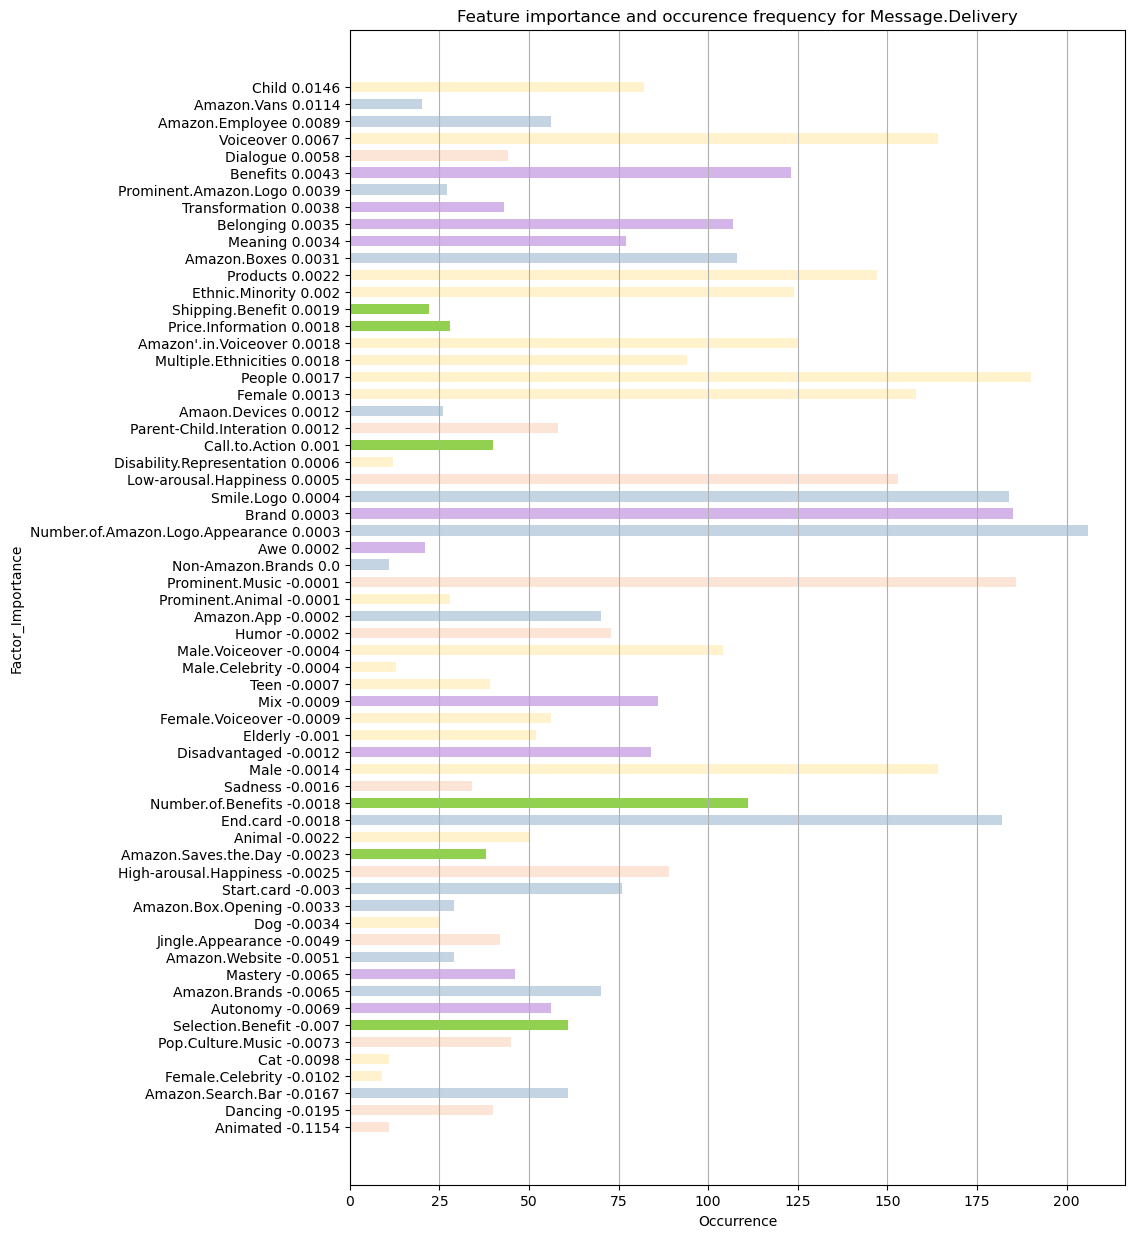

In [8]:
# MSE = []
# RMSE_validation = []
# RMSE_test = []
# R_squared_test = []
# R_squared_validation = []
# feature_importance = []

# data_bar = tqdm(range(12))
for index in range(1,12):
    y = Y[Y.columns[index]]
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=0)  
    
    #网格搜索参数优化
    params = {
        "n_estimators":[10,50,100,150,200],
        'max_depth':[10,15],
        'max_features':[5,20,30],
        'min_samples_leaf':[1,2,4,6],
        'min_samples_split':[4,8,10]
        
    }
    
    RF_regression = RandomForestRegressor()
    model = GridSearchCV(RF_regression, param_grid=params, cv=5)
    model.fit(X_train, y_train)
    n_estimators = model.best_params_["n_estimators"]
    max_depth = model.best_params_["max_depth"]
    max_features = model.best_params_["max_features"]
    min_samples_leaf = model.best_params_["min_samples_leaf"]
    min_samples_split = model.best_params_["min_samples_split"]

    # RF_regression = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    # cv_score = cross_validate(RF_regression       #实例化的模型
	# 			, X   #完整的特征值
	# 			, y #完整的目标值
	# 			, cv=10         #几折交叉验证
	# 			,scoring = ["neg_mean_squared_error","neg_root_mean_squared_error","r2"]   
	# 			)

    # MSE.append(cv_score["test_neg_mean_squared_error"].mean())
    # RMSE_validation.append(cv_score["test_neg_root_mean_squared_error"].mean())
    # R_squared_validation.append(cv_score["test_r2"].mean())


    RF_regression = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
    RF_regression.fit(X, y)

    ###################################################
    shap_values = shap.TreeExplainer(RF_regression).shap_values(X)

    # shap.summary_plot(shap_values, X, show = False)
    # plt.savefig("./plots/feature/{}.png".format(Y.columns[i]))


    temp = np.array(shap_values) * np.array(X)
    importance_dic = {}

    for i in range(62):
        importance_dic[X.columns[i]] = round(temp[:,i].sum() / dic[X.columns[i]], 4)

    importance_dic = dict(sorted(importance_dic.items(), key=lambda x:x[1], reverse=False))
    occurance = []
    for i in list(importance_dic.keys()):
        occurance.append(dic[i])
    color = []
    for i in importance_dic.keys():
        color.append(color_dic[i])

    x = []
    for i in importance_dic.keys():
        x.append(i+" "+str(importance_dic[i]))

    x = np.array(x)
    y = np.array(occurance)
    plt.subplots(figsize=(10, 15))
    plt.title("Feature importance and occurence frequency for {}".format(Y.columns[index]))
    plt.ylabel("Factor_Importance")
    plt.xlabel("Occurrence")
    plt.grid(axis='x')
    plt.barh(x,y,height=0.6, color = color, )
    plt.savefig("./plots/feature/{}.png".format(Y.columns[index]))

    break
    ###################################################

    # joblib.dump(RF_regression, "model/RF_optimized_regression/model{}.pkl".format(i+1))
    # R_squared_test.append(RF_regression.score(X_test,y_test))
    # RMSE_test.append(math.sqrt(metrics.mean_squared_error(y_test, RF_regression.predict(X_test))))
    # feature_importance.append(list(RF_regression.feature_importances_))

In [ ]:
MSE = np.array(MSE) * -1
RMSE_validation = np.array(RMSE_validation) * -1
result_dic = {"MSE":MSE, "RMSE_validation":RMSE_validation, "RMSE_test":RMSE_test, "R_squared_validation":R_squared_validation, "R_squared_test":R_squared_test}
result_df = pd.DataFrame(result_dic, index=Y.columns)
result_df.to_csv("result/RF_optimized_regression.csv")

feature_importance_df = pd.DataFrame(feature_importance, columns=X.columns, index=Y.columns)
feature_importance_df.to_csv("result/RFR_optimized_feature_importance.csv")

In [ ]:
# 统计特征重要性
import os
from pyecharts import options as opts
from pyecharts.charts import Bar
from pyecharts.globals import ThemeType

Feature = [round(i,3)for i in list(RandomForest.feature_importances_*100)]
Columns = list(X.columns)
c = (
    Bar({"theme": ThemeType.MACARONS})
    .add_xaxis(Columns)
    .add_yaxis("Feature", Feature)
    .reversal_axis()
    .set_series_opts(label_opts=opts.LabelOpts(position="right",
                                               formatter="{c} %"))
    .set_global_opts(title_opts=opts.TitleOpts(title="Feature Importances"),
                    xaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value} %")))
)


PATH = './plots/'
if not os.path.exists(PATH):  # 如果路径不存在
    os.makedirs(PATH)
    
c.render("./plots/RandomForestClassifier_feature_importances.html")
